In [124]:
#####Hierarchical Non Negative Matrix Factorization#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [125]:
####データの発生####
##データの設定
k = 10   #基底数
hh = 5000   #ユーザー数
item = 2500   #アイテム数
pt = np.random.poisson(np.random.gamma(25.0, 1/0.25, hh), hh)   #ユーザーあたりのレコード数
hhpt = np.sum(pt)   #
vec_k = np.repeat(1, k)

In [126]:
##IDとインデックスを設定
#IDを設定
user_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスを設定
index = np.arange(hhpt)
user_list = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]

In [127]:
##アイテムの割当を生成
#セグメント割当を生成
topic = 25
phi = np.random.dirichlet(np.repeat(0.5, item), topic)
theta = np.random.dirichlet(np.repeat(2.5, topic), hh)
z = np.dot(np.array([np.random.multinomial(1, theta[i, :], 1) for i in range(hh)]).reshape(hh, topic), range(topic))

#多項分布からアイテムを生成
item_id = np.zeros(hhpt, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id[user_list[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt[i]), range(item))
    
#インデックスの設定
item_list = [j for j in range(item)]
item_vec = [j for j in range(item)]
item_n = np.repeat(0, item)
for j in range(item):
    item_list[j] = index[item_id==j]
    item_vec[j] = np.repeat(1, len(item_list[j]))
    item_n[j] = len(item_list[j])

0
1000
2000
3000
4000


In [128]:
##階層モデルの説明変数を生成
#ユーザーの説明変数を生成
k1 = 3; k2 = 5; k3 = 5
u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
u2 = np.zeros((hh, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    u2[:, j] = np.random.binomial(1, prob, hh)
u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
u = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)
col_u = u.shape[1]

#アイテムの説明変数を生成
k1 = 4; k2 = 5; k3 = 4
v1 = np.array(np.random.random(item*k1)).reshape((item, k1))
v2 = np.zeros((item, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    v2[:, j] = np.random.binomial(1, prob, item)
v3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), item)
v3 = np.delete(v3, np.argmin(np.sum(v3, axis=0)), axis=1)   #冗長な変数の削除
v = np.concatenate((np.repeat(1, item)[:, np.newaxis], v1, v2, v3), axis=1)
col_v = v.shape[1]

In [129]:
####応答変数の生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)

    ##NMFのパラメータを生成
    #ガンマ分布の尺度パラメータを生成
    alpha_u = np.random.normal(0, 0.5, k*col_u).reshape(col_u, k)
    alpha_v = np.random.normal(0, 0.5, k*col_v).reshape(col_v, k)
    alpha_ut = alpha_u; alpha_vt = alpha_v
    lambda_u = np.exp(np.dot(u, alpha_u))
    lambda_v = np.exp(np.dot(v, alpha_v))

    #ガンマ分布の形状パラメータを生成
    beta_u = np.abs(np.random.normal(1.0, 0.5, 1))
    beta_v = np.abs(np.random.normal(1.0, 0.5, 1))
    beta_ut = beta_u; beta_vt = beta_v

    #ガンマ分布から行列分解のパラメータを生成
    theta_u = np.random.gamma(lambda_u, 1/beta_u)
    theta_v = np.random.gamma(lambda_v, 1/beta_v)
    theta_ut = theta_u; theta_vt = theta_v

    ##ポアソン分布から応答変数を生成
    WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)
    y = np.random.poisson(WH, hhpt)
    y_vec = y.reshape(hhpt, 1)
    
    #break条件
    if (np.max(y) < 100) & (np.max(y) > 25):
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268


3576733
7.152950987528898


(array([3.73642e+05, 1.00593e+05, 1.95140e+04, 4.72400e+03, 1.03100e+03,
        3.31000e+02, 1.35000e+02, 4.30000e+01, 1.80000e+01, 5.00000e+00]),
 array([ 0. ,  9.3, 18.6, 27.9, 37.2, 46.5, 55.8, 65.1, 74.4, 83.7, 93. ]),
 <a list of 10 Patch objects>)

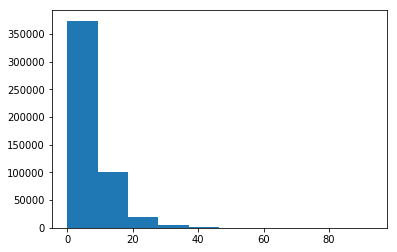

In [130]:
#生成した応答変数を確認
print(np.sum(y))
print(np.mean(y))
plt.hist(y)

In [131]:
####テストデータを作成####
##IDとインデックスを作成
pt0 = np.repeat(100, hh)
hhpt0 = np.sum(pt0)
user_id0 = np.repeat(range(hh), pt0)
pt_id0 = np.array(list(itertools.chain(*[np.array(range(pt0[i]), dtype="int") for i in range(hh)])))

#インデックスを設定
index = np.arange(hhpt0)
user_list0 = [i for i in range(hh)]
for i in range(hh):
    user_list0[i] = index[user_id0==i]
    
#多項分布からアイテムを生成
item_id0 = np.zeros(hhpt0, dtype='int')
for i in range(hh):
    if i%1000==0:
        print(i)
    item_id0[user_list0[i]] = np.dot(np.random.multinomial(1, phi[z[i], :], pt0[i]), range(item))

0
1000
2000
3000
4000


In [132]:
##応答変数の生成
#期待値を設定
W0 = theta_u[user_id0, ]
H0 = theta_v[item_id0, ]

#ポアソン分布から応答変数を生成
WH0 = np.dot(theta_u[user_id0, ] * theta_v[item_id0, ], vec_k)
y0 = np.random.poisson(WH0, hhpt0)
y_vec0 = y0.reshape(hhpt0, 1)

In [133]:
####マルコフ連鎖モンテカルロ法でHierarchical NMFを推定####
##HMCで尺度パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_alpha(alpha, beta, tau_inv, d, d_log, x):

    #ガンマ回帰モデルの対数尤度
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)   
    Lho = np.sum(beta * (-d/Lambda - mu) + beta*np.log(beta) - math.lgamma(beta) + (beta-1)*d_log)

    #多変量正規分布の対数事前分布
    log_mvn = -1/2 * np.dot(np.dot(alpha, tau_inv), alpha)

    #対数事後分布の和
    LL = Lho + log_mvn
    return LL

In [134]:
#ガンマ回帰の対数事後分布の微分関数
def dloglike_alpha(alpha, beta, tau_inv, d, d_log, x, n):

    #期待値の設定
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)

    #微分関数の設定
    dlgamma = np.sum(((d-Lambda) / (np.power(Lambda, 2)/beta) * Lambda).reshape(n, 1) * x, axis=0)
    dmvn = np.dot(-tau_inv, alpha)

    #対数事後分布の微分関数の和
    LLd = -(dlgamma + dmvn)
    return LLd

In [135]:
#リープフロッグ法を解く関数
def leapfrog_alpha(r, z1, D, e, L, beta, tau_inv, d, d_log, x, n): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, beta, tau_inv, d, d_log, x, n) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, beta, tau_inv, d, d_log, x, n) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [136]:
##HMCで形状パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_beta(beta, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k):

    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #ガンマ回帰モデルの対数尤度
    Lho1 = np.sum(beta_u * (-d1/Lambda_u - mu_u) + beta_u*np.log(beta_u) - math.lgamma(beta_u) + (beta_u-1)*d_log1)
    Lho2 = np.sum(beta_v * (-d2/Lambda_v - mu_v) + beta_v*np.log(beta_v) - math.lgamma(beta_v) + (beta_v-1)*d_log2)

    #対数事後分布の和
    LL = Lho1 + Lho2
    return LL

In [137]:
#形状パラメータの微分関数
def dloglike_beta(beta, alpha_u, alpha_v, d1, d2, u, v, hh, item, k):
    
    #パラメータを設定
    beta_u = beta[0]
    beta_v = beta[1]
    
    #期待値の設定
    mu_u = np.dot(u, alpha_u).reshape(-1)
    mu_v = np.dot(v, alpha_v).reshape(-1)
    Lambda_u = np.exp(mu_u)
    Lambda_v = np.exp(mu_v)
    
    #微分関数の和
    dlgamma_u = (hh*k)*(np.log(beta_u) - scipy.special.digamma(beta_u)) + np.sum(1 - d1/Lambda_u + np.log(d1/Lambda_u))
    dlgamma_v = (item*k)*(np.log(beta_v) - scipy.special.digamma(beta_v)) + np.sum(1 - d2/Lambda_v + np.log(d2/Lambda_v))
    dlgamma = -np.append(dlgamma_u, dlgamma_v)
    return dlgamma

In [138]:
#リープフロッグ法を解く関数
def leapfrog_beta(r, z1, D, e, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, alpha_u, alpha_v, d1, d2, u, v, hh, item, k) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, alpha_u, alpha_v, d1, d2, u, v, hh, item, k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [139]:
##アルゴリズムの設定
R = 2000
keep = 4
burnin = int(500/keep)
iter = 0
disp = 10
e1 = 0.001
e2 = 0.0025
L = 3

In [172]:
##事前分布の設定
#モデルパラメータの事前分布
gamma_u = np.repeat(0, col_u)
gamma_v = np.repeat(0, col_v)
tau_inv1 = np.linalg.inv(np.diag(np.repeat(100, col_u)))
tau_inv2 = np.linalg.inv(np.diag(np.repeat(100, col_v)))
tau_inv = np.linalg.inv(np.diag(np.repeat(100, k)))

#ハイパーパラメータの設定
par = 200
omega1 = par/pt.reshape(hh, 1); omega1[omega1 < 1, ] = 1
omega2 = par/item_n.reshape(item, 1); omega2[omega2 < 1] = 1

In [173]:
##パラメータの真値
#ガンマ分布の尺度パラメータの真値
alpha_u = alpha_ut
alpha_v = alpha_vt
lambda_u = np.exp(np.dot(u, alpha_u))
lambda_v = np.exp(np.dot(v, alpha_v))

#ガンマ分布の形状パラメータの真値
beta_u = beta_ut
beta_v = beta_vt

#行列分解のパラメータの真値
theta_u = theta_ut
theta_v = theta_vt
WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)   #期待値

In [174]:
##パラメータの初期値
#ガンマ分布の尺度パラメータの初期値
alpha_u = np.random.normal(0, 0.1, k*col_u).reshape(col_u, k)
alpha_v = np.random.normal(0, 0.1, k*col_v).reshape(col_v, k)
lambda_u = np.exp(np.dot(u, alpha_u))
lambda_v = np.exp(np.dot(v, alpha_v))

#ガンマ分布の形状パラメータを初期値
beta_u = 1.0
beta_v = 1.0

#ガンマ分布から行列分解のパラメータを生成
theta_u = np.random.gamma(lambda_u, 1/beta_u)
theta_v = np.random.gamma(lambda_v, 1/beta_v)
WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)   #期待値

In [175]:
##サンプリング結果の格納用配列
THETA_U = np.zeros((hh, k, int(R/keep)))
THETA_V = np.zeros((item, k, int(R/keep)))
ALPHA_U = np.zeros((col_u, k, int(R/keep)))
ALPHA_V = np.zeros((col_v, k, int(R/keep)))
BETA_U = np.zeros((int(R/keep)))
BETA_V = np.zeros((int(R/keep))) 

In [176]:
##ユーザーおよびアイテムのインデックスを作成
#スパース行列作成用のid
no_id = np.repeat(np.arange(hhpt), k)
k_id = np.repeat(np.arange(k), hhpt).reshape(hhpt, k, order="F").reshape(-1)

#個別に和を取るためのスパース行列
user_dt = sparse.coo_matrix((np.repeat(1, hhpt), (user_id, range(hhpt))), shape=(hh, hhpt)).tocsr()
item_dt = sparse.coo_matrix((np.repeat(1, hhpt), (item_id, range(hhpt))), shape=(item, hhpt)).tocsr()

In [177]:
##対数尤度の基準値
#1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.poisson.logpmf(y, np.mean(y)))
print(LLst)

#真値での対数尤度
WH_T = np.dot(theta_ut[user_id, ] * theta_vt[item_id, ], vec_k)   
WH_T0 = np.dot(theta_ut[user_id0, ] * theta_vt[item_id0, ], vec_k)
LLbest = np.sum(scipy.stats.poisson.logpmf(y, WH_T))
LLbest0 = np.sum(scipy.stats.poisson.logpmf(y0, WH_T0))
print(LLbest)
print(LLbest0)

-1988755.5986004088
-1126153.9494703237
-1125846.4560504747


In [178]:
####パラメータをサンプリング####
for rp in range(R):

    ##ユーザー特徴行列をサンプリング
    #補助変数gammaを更新
    theta_vec2 = theta_v[item_id, ]
    gamma = (theta_u[user_id, ] * theta_vec2) / WH.reshape(hhpt, 1)

    #ユーザーごとのガンマ分布のパラメータを設定
    gamma_y = gamma * y_vec   #要素ごとの期待値
    W1 = np.array(np.dot(user_dt, sparse.coo_matrix((gamma_y.reshape(-1), (no_id, k_id)),
                                                    shape=(hhpt, k)).tocsr()).todense()) + omega1*lambda_u
    W2 = np.array(np.dot(user_dt, sparse.coo_matrix((theta_vec2.reshape(-1), (no_id, k_id)), 
                                                    shape=(hhpt, k)).tocsr()).todense()) + omega1*beta_u

    #ガンマ分布よりパラメータをサンプリング
    theta_u = np.random.gamma(W1, 1/W2)
    theta_u = theta_u / np.repeat(np.sum(theta_u, axis=0), hh).reshape(hh, k, order="F") * hh/(k/5)   #各列ベクトルを正規化
    
    ##アイテム特徴行列をサンプリング
    #補助変数gammaを更新
    theta_vec1 = theta_u[user_id, ]
    WH = np.dot(theta_vec1 * theta_vec2, vec_k)   
    gamma = (theta_vec1 * theta_vec2) / WH.reshape(hhpt, 1)

    #ユーザーごとのガンマ分布のパラメータを設定
    gamma_y = gamma * y_vec   #要素ごとの期待値
    H1 = np.array(np.dot(item_dt, sparse.coo_matrix((gamma_y.reshape(-1), (no_id, k_id)), 
                                                    shape=(hhpt, k)).tocsr()).todense()) + omega2*lambda_v
    H2 = np.array(np.dot(item_dt, sparse.coo_matrix((theta_vec1.reshape(-1), (no_id, k_id)), 
                                                    shape=(hhpt, k)).tocsr()).todense()) + omega2*beta_v

    #ガンマ分布よりパラメータをサンプリング
    theta_v = np.random.gamma(H1, 1/H2)
    WH = np.dot(theta_vec1 * theta_v[item_id, ], vec_k)


    ##階層モデルのパラメータをサンプリング
    #採択率の格納用ベクトル
    accept_prob_u = np.repeat(0.0, k)
    accept_prob_v = np.repeat(0.0, k)

    for j in range(k):
        ##ユーザー特徴行列の尺度パラメータをサンプリング
        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, col_u)
        alphad = alpha_u[:, j]

        #リープフロッグ法による1ステップ移動
        d = theta_u[:, j]; d_log = np.log(d)
        res = leapfrog_alpha(rold, alphad, dloglike_alpha, e1, L, beta_u, tau_inv1, d, d_log, u, hh)
        rnew = res[0]
        alphan = res[1]

        #移動前と移動後のハミルトニアン
        Hnew = -loglike_alpha(alphan, beta_u, tau_inv1, d, d_log, u) + np.sum(np.power(rnew, 2)) / 2
        Hold = -loglike_alpha(alphad, beta_u, tau_inv1, d, d_log, u) + np.sum(np.power(rold, 2)) / 2

        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, 1)
        accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
        accept_prob_u[j] = accept_prob

        #採択率に基づきalphaを採択
        if(accept_prob >= rand):
            alpha_u[:, j] = alphan
        else:
            alpha_u[:, j] = alphad

        ##アイテム特徴行列の尺度パラメータをサンプリング
        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, col_v)
        alphad = alpha_v[:, j]

        #リープフロッグ法による1ステップ移動
        d = theta_v[:, j]; d_log = np.log(d)
        res = leapfrog_alpha(rold, alphad, dloglike_alpha, e1, L, beta_v, tau_inv2, d, d_log, v, item)
        rnew = res[0]
        alphan = res[1]

        #移動前と移動後のハミルトニアン
        Hnew = -loglike_alpha(alphan, beta_v, tau_inv2, d, d_log, v) + np.sum(np.power(rnew, 2)) / 2
        Hold = -loglike_alpha(alphad, beta_v, tau_inv2, d, d_log, v) + np.sum(np.power(rold, 2)) / 2
        
        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, 1)
        accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
        accept_prob_v[j] = accept_prob

        #採択率に基づきalphaを採択
        if(accept_prob >= rand):
            alpha_v[:, j] = alphan
        else:
            alpha_v[:, j] = alphad
    
    #lambdaを更新
    lambda_u = np.exp(np.dot(u, alpha_u))
    lambda_v = np.exp(np.dot(v, alpha_v))

    
    ##尺度パラメータをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.normal(0, 1, 2)
    betad = np.append(beta_u, beta_v)

    #リープフロッグ法による1ステップ移動
    d1 = theta_u.reshape(-1); d2 = theta_v.reshape(-1)
    res = leapfrog_beta(rold, betad, dloglike_beta, e2, L, alpha_u, alpha_v, d1, d2, u, v, hh, item, k)
    rnew = res[0]
    betan = res[1]

    #移動前と移動後のハミルトニアン
    d_log1 = np.log(d1); d_log2 = np.log(d2)
    Hnew = -loglike_beta(betan, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k) + np.sum(np.power(rnew, 2)) / 2
    Hold = -loglike_beta(betad, alpha_u, alpha_v, d1, d2, d_log1, d_log2, u, v, hh, item, k) + np.sum(np.power(rold, 2)) / 2
    
    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, 1)
    accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
    accept_prob_a = accept_prob

    #採択率に基づきgammaを採択
    if(accept_prob >= rand):
        beta = betan
        beta_u = beta[0]; beta_v = beta[1]
    else:
        beta = betad
        beta_u = beta[0]; beta_v = beta[1]
    

    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        THETA_U[:, :, mkeep] = theta_u
        THETA_V[:, :, mkeep] = theta_v
        ALPHA_U[:, :, mkeep] = alpha_u
        ALPHA_V[:, :, mkeep] = alpha_v
        BETA_U[mkeep] = beta_u
        BETA_V[mkeep] = beta_v

    if rp%disp==0:
        #対数尤度を更新
        WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)   
        WH0 = np.dot(theta_u[user_id0, ] * theta_v[item_id0, ], vec_k)   
        LL = np.sum(scipy.stats.poisson.logpmf(y, WH))
        LL0 = np.sum(scipy.stats.poisson.logpmf(y0, WH0))

        #サンプリング結果を表示
        print(rp)
        print(np.round([LL, LLst, LLbest], 1))
        print(np.round([LL0, LLbest0], 1))
        print(np.round(accept_prob_a, 3))
        print(np.round(np.vstack((accept_prob_u, accept_prob_v)), 3))
        print(np.round([beta_u, beta_v, beta_ut, beta_vt], 3))

0
[-1448537.1 -1988755.6 -1126153.9]
[-1483337.9 -1125846.5]
1.0
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[0.865 0.97  2.456 1.382]
10
[-1312883.2 -1988755.6 -1126153.9]
[-1378571.4 -1125846.5]
1.0
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[1.452 1.306 2.456 1.382]
20
[-1225919.  -1988755.6 -1126153.9]
[-1296017.1 -1125846.5]
1.0
[[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.998 1.    1.    1.    1.    1.    1.    1.    1.    0.997]]
[1.377 1.353 2.456 1.382]
30
[-1189780.6 -1988755.6 -1126153.9]
[-1259205.6 -1125846.5]
1.0
[[1.    1.    1.    1.    1.    1.    0.998 1.    0.999 1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[1.245 1.275 2.456 1.382]
40
[-1169884.5 -1988755.6 -1126153.9]
[-1238511.9 -1125846.5]
1.0
[[0.995 1.    0.989 0.993 1.    1.    1.    0.999 1.    1.   ]
 [1.    1.    0.998 1.    1.    1.    1.    1.    1.    1.   ]]
[1.192 1.245 2.456 1.382]
50
[-1156264.4 -1988755.6 

380
[-1116392.4 -1988755.6 -1126153.9]
[-1180070.8 -1125846.5]
1.0
[[1.    1.    1.    1.    1.    1.    1.    1.    1.    0.999]
 [1.    1.    1.    0.999 0.999 1.    1.    1.    1.    1.   ]]
[0.979 1.212 2.456 1.382]
390
[-1116246.9 -1988755.6 -1126153.9]
[-1179407.1 -1125846.5]
1.0
[[1.    0.997 1.    1.    1.    1.    1.    1.    1.    1.   ]
 [0.999 0.999 1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.976 1.215 2.456 1.382]
400
[-1116132.1 -1988755.6 -1126153.9]
[-1179611.  -1125846.5]
1.0
[[1.    1.    1.    1.    1.    0.998 1.    1.    1.    1.   ]
 [1.    1.    1.    1.    0.999 1.    1.    1.    1.    1.   ]]
[0.967 1.225 2.456 1.382]
410
[-1115970.2 -1988755.6 -1126153.9]
[-1179339.1 -1125846.5]
1.0
[[1.    0.998 1.    1.    1.    1.    0.999 1.    1.    0.998]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.959 1.208 2.456 1.382]
420
[-1115878.6 -1988755.6 -1126153.9]
[-1179706.1 -1125846.5]
1.0
[[1.    0.997 1.    1.    1.    0.998 0.999 0.998 1. 

760
[-1114551.7 -1988755.6 -1126153.9]
[-1178006.4 -1125846.5]
1.0
[[1.    1.    1.    1.    0.998 1.    0.998 1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.914 1.108 2.456 1.382]
770
[-1114626.9 -1988755.6 -1126153.9]
[-1178130.3 -1125846.5]
1.0
[[1.    1.    1.    1.    0.996 1.    1.    1.    1.    1.   ]
 [1.    0.999 1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.915 1.108 2.456 1.382]
780
[-1114500.5 -1988755.6 -1126153.9]
[-1177572.5 -1125846.5]
1.0
[[1.    1.    1.    1.    1.    1.    1.    0.996 1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.924 1.099 2.456 1.382]
790
[-1114569.3 -1988755.6 -1126153.9]
[-1177851.1 -1125846.5]
1.0
[[0.999 0.998 1.    1.    0.997 1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    0.999 1.    0.999 1.    1.   ]]
[0.919 1.105 2.456 1.382]
800
[-1114526.1 -1988755.6 -1126153.9]
[-1178138.7 -1125846.5]
1.0
[[1.    0.999 1.    1.    0.999 1.    1.    0.998 1. 

1140
[-1113931.9 -1988755.6 -1126153.9]
[-1176724.4 -1125846.5]
1.0
[[0.998 1.    1.    1.    1.    1.    0.998 1.    1.    0.999]
 [1.    1.    0.999 1.    1.    1.    1.    1.    1.    1.   ]]
[0.9   1.027 2.456 1.382]
1150
[-1114227.3 -1988755.6 -1126153.9]
[-1177379.7 -1125846.5]
1.0
[[1.    0.999 1.    1.    0.999 1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    0.999 1.   ]]
[0.905 1.027 2.456 1.382]
1160
[-1114188.3 -1988755.6 -1126153.9]
[-1177202.7 -1125846.5]
1.0
[[0.997 1.    0.998 0.999 1.    0.999 0.999 1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    0.999 1.   ]]
[0.912 1.025 2.456 1.382]
1170
[-1114210.1 -1988755.6 -1126153.9]
[-1176634.9 -1125846.5]
1.0
[[1.    0.999 1.    0.999 1.    1.    1.    1.    1.    0.999]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.89  1.015 2.456 1.382]
1180
[-1114164.5 -1988755.6 -1126153.9]
[-1176841.  -1125846.5]
1.0
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1

1520
[-1113958.5 -1988755.6 -1126153.9]
[-1176484.  -1125846.5]
1.0
[[1.    0.999 1.    1.    1.    1.    1.    1.    0.999 1.   ]
 [1.    0.999 0.999 1.    1.    1.    1.    1.    1.    1.   ]]
[0.897 0.972 2.456 1.382]
1530
[-1114111.  -1988755.6 -1126153.9]
[-1176973.  -1125846.5]
1.0
[[1.    1.    1.    1.    1.    1.    1.    1.    1.    0.998]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.892 0.959 2.456 1.382]
1540
[-1114057.  -1988755.6 -1126153.9]
[-1176761.4 -1125846.5]
1.0
[[0.999 1.    1.    1.    0.998 1.    1.    1.    1.    0.998]
 [1.    1.    1.    1.    0.999 1.    1.    1.    1.    1.   ]]
[0.905 0.969 2.456 1.382]
1550
[-1114029.  -1988755.6 -1126153.9]
[-1176730.5 -1125846.5]
1.0
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[0.897 0.954 2.456 1.382]
1560
[-1113962.9 -1988755.6 -1126153.9]
[-1176911.6 -1125846.5]
1.0
[[0.999 1.    1.    0.999 1.    1.    1.    1.    1.    0.999]
 [1.    1.    1.    1.    1.    1.    1.    1

1900
[-1114020.2 -1988755.6 -1126153.9]
[-1176309.5 -1125846.5]
1.0
[[1.    1.    1.    0.999 1.    1.    0.999 1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.885 0.958 2.456 1.382]
1910
[-1114022.6 -1988755.6 -1126153.9]
[-1176314.5 -1125846.5]
0.96
[[1.    1.    1.    1.    0.998 1.    1.    1.    1.    1.   ]
 [1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.893 0.952 2.456 1.382]
1920
[-1113760.4 -1988755.6 -1126153.9]
[-1176364.1 -1125846.5]
1.0
[[1.    0.999 1.    1.    1.    1.    1.    1.    0.999 1.   ]
 [1.    0.998 1.    1.    1.    1.    1.    1.    1.    1.   ]]
[0.876 0.935 2.456 1.382]
1930
[-1113847.1 -1988755.6 -1126153.9]
[-1176199.2 -1125846.5]
1.0
[[0.996 1.    1.    1.    1.    1.    1.    0.998 0.996 0.999]
 [0.999 1.    0.999 1.    1.    1.    1.    1.    1.    1.   ]]
[0.865 0.946 2.456 1.382]
1940
[-1114016.1 -1988755.6 -1126153.9]
[-1176313.7 -1125846.5]
0.994
[[0.996 1.    1.    1.    0.998 0.999 1.    0

In [179]:
####非負値行列因子分解との比較#####
##アルゴリズムの設定
#事前分布の設定
alpha1 = 0.01; beta1 = 0.01
alpha2 = 0.01; beta2 = 0.01

#初期値の設定
theta_u = numpy.random.gamma(0.1, 1/0.1, hh*k).reshape(hh, k)
theta_v = numpy.random.gamma(0.1, 1/0.1, item*k).reshape(item, k)

In [ ]:
##パラメータをサンプリング
for rp in range(R):

    ##ユーザー特徴行列をサンプリング
    #補助変数gammaを更新
    theta_vec2 = theta_v[item_id, ]
    gamma = (theta_u[user_id, ] * theta_vec2) / WH.reshape(hhpt, 1)

    #ユーザーごとのガンマ分布のパラメータを設定
    gamma_y = gamma * y_vec   #要素ごとの期待値
    W1 = np.array(np.dot(user_dt, sparse.coo_matrix((gamma_y.reshape(-1), (no_id, k_id)),
                                                    shape=(hhpt, k)).tocsr()).todense()) + alpha1
    W2 = np.array(np.dot(user_dt, sparse.coo_matrix((theta_vec2.reshape(-1), (no_id, k_id)), 
                                                    shape=(hhpt, k)).tocsr()).todense()) + beta1

    #ガンマ分布よりパラメータをサンプリング
    theta_u = np.random.gamma(W1, 1/W2)
    theta_u = theta_u / np.repeat(np.sum(theta_u, axis=0), hh).reshape(hh, k, order="F") * hh/(k/5)   #各列ベクトルを正規化
    
    ##アイテム特徴行列をサンプリング
    #補助変数gammaを更新
    theta_vec1 = theta_u[user_id, ]
    WH = np.dot(theta_vec1 * theta_vec2, vec_k)   
    gamma = (theta_vec1 * theta_vec2) / WH.reshape(hhpt, 1)

    #ユーザーごとのガンマ分布のパラメータを設定
    gamma_y = gamma * y_vec   #要素ごとの期待値
    H1 = np.array(np.dot(item_dt, sparse.coo_matrix((gamma_y.reshape(-1), (no_id, k_id)), 
                                                    shape=(hhpt, k)).tocsr()).todense()) + alpha2
    H2 = np.array(np.dot(item_dt, sparse.coo_matrix((theta_vec1.reshape(-1), (no_id, k_id)), 
                                                    shape=(hhpt, k)).tocsr()).todense()) + beta2

    #ガンマ分布よりパラメータをサンプリング
    theta_v = np.random.gamma(H1, 1/H2)
    WH = np.dot(theta_vec1 * theta_v[item_id, ], vec_k)
    
    if rp%disp==0:
        #対数尤度を更新
        WH = np.dot(theta_u[user_id, ] * theta_v[item_id, ], vec_k)   
        WH0 = np.dot(theta_u[user_id0, ] * theta_v[item_id0, ], vec_k)   
        LL = np.sum(scipy.stats.poisson.logpmf(y, WH))
        LL0 = np.sum(scipy.stats.poisson.logpmf(y0, WH0))

        #サンプリング結果を表示
        print(rp)
        print(np.round([LL, LLst, LLbest], 1))
        print(np.round([LL0, LLbest0], 1))

0
[-5688516.6 -1988755.6 -1126153.9]
[-5952308.1 -1125846.5]
10
[-1426099.6 -1988755.6 -1126153.9]
[-1562621.4 -1125846.5]
20
[-1391817.8 -1988755.6 -1126153.9]
[-1533807.2 -1125846.5]
30
[-1371213.8 -1988755.6 -1126153.9]
[-1517419.1 -1125846.5]
40
[-1353062.2 -1988755.6 -1126153.9]
[-1498629.5 -1125846.5]
50
[-1337378.2 -1988755.6 -1126153.9]
[-1481529.3 -1125846.5]
60
[-1323892.4 -1988755.6 -1126153.9]
[-1465554.9 -1125846.5]
70
[-1312213.2 -1988755.6 -1126153.9]
[-1450309.  -1125846.5]
80
[-1301817.8 -1988755.6 -1126153.9]
[-1438516.9 -1125846.5]
90
[-1292025.6 -1988755.6 -1126153.9]
[-1427408.  -1125846.5]
100
[-1283712.2 -1988755.6 -1126153.9]
[-1417092.2 -1125846.5]
110
[-1276421.4 -1988755.6 -1126153.9]
[-1408791.6 -1125846.5]
120
[-1269562.  -1988755.6 -1126153.9]
[-1398496.8 -1125846.5]
130
[-1263015.7 -1988755.6 -1126153.9]
[-1390793.1 -1125846.5]
140
[-1257271.1 -1988755.6 -1126153.9]
[-1382203.3 -1125846.5]
150
[-1251652.3 -1988755.6 -1126153.9]
[-1375665.6 -1125846.5]
160

1300
[-1135899.2 -1988755.6 -1126153.9]
[-1222892.6 -1125846.5]
1310
[-1135919.2 -1988755.6 -1126153.9]
[-1224038.5 -1125846.5]
1320
[-1135800.  -1988755.6 -1126153.9]
[-1223425.7 -1125846.5]
1330
[-1135549.4 -1988755.6 -1126153.9]
[-1223303.5 -1125846.5]
1340
[-1135524.5 -1988755.6 -1126153.9]
[-1223295.1 -1125846.5]
1350
[-1135216.4 -1988755.6 -1126153.9]
[-1222631.3 -1125846.5]
1360
[-1134937.7 -1988755.6 -1126153.9]
[-1222856.  -1125846.5]
1370
[-1134787.  -1988755.6 -1126153.9]
[-1223431.8 -1125846.5]
1380
[-1134744.2 -1988755.6 -1126153.9]
[-1221754.5 -1125846.5]
1390
[-1134566.3 -1988755.6 -1126153.9]
[-1222487.4 -1125846.5]
1400
[-1134704.5 -1988755.6 -1126153.9]
[-1221145.  -1125846.5]
1410
[-1134499.9 -1988755.6 -1126153.9]
[-1222186.4 -1125846.5]
1420
[-1134454.1 -1988755.6 -1126153.9]
[-1222786.  -1125846.5]
1430
[-1134350.1 -1988755.6 -1126153.9]
[-1222675.5 -1125846.5]
1440
[-1134054.6 -1988755.6 -1126153.9]
[-1221941.1 -1125846.5]
1450
[-1134171.6 -1988755.6 -1126153.9]
